In [ ]:
# !git clone https://github.com/Kiran5867/Stock-LNN.git

### RNN

In [ ]:
!pip install numpy
!pip install pandas
!pip install torch
!pip install scikit-learn
!pip install matplotlib
!pip install yfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 65.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import yfinance as yf
import sys
# sys.path.append('/content/Stock-LNN')
# import rnn
# import ltc
# import viz

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define sequence data creation function
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Define MASE calculation function
def calculate_mase(actual, predicted, seasonal_period=1):
    mae_forecast = np.mean(np.abs(actual - predicted))
    mae_naive = np.mean(np.abs(actual[seasonal_period:] - actual[:-seasonal_period]))
    return mae_forecast / mae_naive if mae_naive != 0 else float('inf')

# Define multi-sequence prediction model with 5 layers of LTC
class MultiFeatureRNN(nn.Module):
    def __init__(self, input_size=2, hidden_size=50, output_size=2):
        super(MultiFeatureRNN, self).__init__()

        # Define a 5-layer RNN, where each layer receives the output of the previous layer
        self.rnn_layer1 = nn.RNN(input_size, hidden_size, batch_first=True)
        self.rnn_layer2 = nn.RNN(hidden_size, hidden_size, batch_first=True)
        self.rnn_layer3 = nn.RNN(hidden_size, hidden_size, batch_first=True)

        # Output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Sequentially pass data through each RNN layer
        out, _ = self.rnn_layer1(x)
        out, _ = self.rnn_layer2(out)
        out, _ = self.rnn_layer3(out)

        # Take the output of the last time step
        out = self.fc(out[:, -1, :])
        return out


# Training function
def train_model(train_loader, val_loader, model, criterion, optimizer, epochs=30):
    best_val_loss = float('inf')
    best_epoch = 0
    best_model_state = None

    start_time = time.time()
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            # Move data to GPU if available
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validate the model
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                # Move data to GPU if available
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                output = model(X_batch)
                loss = criterion(output, y_batch)
                val_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        # Save the best model state
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_epoch = epoch + 1
            best_model_state = model.state_dict()

        print(f'Epoch {epoch+1}/{epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

    end_time = time.time()
    print(f"Total training time: {end_time - start_time:.2f} seconds")
    print(f"Best model achieved at epoch {best_epoch} with validation loss: {best_val_loss:.4f}")
    model.load_state_dict(best_model_state)
    return model,end_time - start_time

# Evaluation function
def evaluate_model(test_loader, model):
    model.eval()
    with torch.no_grad():
        predictions, actuals = [], []
        for X_batch, y_batch in test_loader:
            # Move data to GPU if available
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)
            predictions.extend(output.cpu().numpy())
            actuals.extend(y_batch.cpu().numpy())

    predictions = np.array(predictions)
    actuals = np.array(actuals)

    # Calculate MSE and MASE
    mse_open = mean_squared_error(actuals[:, 0], predictions[:, 0])
    mse_close = mean_squared_error(actuals[:, 1], predictions[:, 1])
    mase_open = calculate_mase(actuals[:, 0], predictions[:, 0])
    mase_close = calculate_mase(actuals[:, 1], predictions[:, 1])

    # Get current GPU memory usage
    if torch.cuda.is_available():
        allocated_memory = torch.cuda.memory_allocated() / (1024 ** 2)  # Convert to MB
        reserved_memory = torch.cuda.memory_reserved() / (1024 ** 2)  # Convert to MB
    else:
        allocated_memory = reserved_memory = None

    print(f"Test set evaluation metrics (on normalized data):")
    print(f"Open - MSE: {mse_open:.4f}, MASE: {mase_open:.4f}")
    print(f"Close - MSE: {mse_close:.4f}, MASE: {mase_close:.4f}")

    if allocated_memory is not None and reserved_memory is not None:
        print(f"Memory allocated: {allocated_memory:.2f} MB")
        print(f"Memory reserved: {reserved_memory:.2f} MB")

    return predictions, actuals, mse_open, mse_close, mase_open, mase_close, allocated_memory, reserved_memory

# Plot results function
def plot_results(predictions, actuals, title="Comparison of Predicted and Actual Values (Normalized)"):
    results = pd.DataFrame({
        'Predicted Open': predictions[:, 0],
        'Actual Open': actuals[:, 0],
        'Predicted Close': predictions[:, 1],
        'Actual Close': actuals[:, 1]
    })

    plt.figure(figsize=(12, 6))
    plt.plot(results['Actual Open'], label='Actual Open', color='blue')
    plt.plot(results['Predicted Open'], label='Predicted Open', color='red', linestyle='--')
    plt.title(f'Open - {title}')
    plt.xlabel('Time Steps')
    plt.ylabel('Normalized Open')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(results['Actual Close'], label='Actual Close', color='blue')
    plt.plot(results['Predicted Close'], label='Predicted Close', color='red', linestyle='--')
    plt.title(f'Close - {title}')
    plt.xlabel('Time Steps')
    plt.ylabel('Normalized Close')
    plt.legend()
    plt.show()




Loading data sets for time series processing

In [ ]:
stock_data = yf.download('NVDA', start='2020-01-01', end='2023-01-01')
features = stock_data[['Open', 'Close']]
scaler = MinMaxScaler(feature_range=(0, 1))
features_scaled = scaler.fit_transform(features)
X, y = create_sequences(features_scaled, seq_length=30)
split_ratio = 0.8
split = int(len(X) * split_ratio)
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]
X_train, y_train = torch.Tensor(X_train).to(device), torch.Tensor(y_train).to(device)
X_val, y_val = torch.Tensor(X_val).to(device), torch.Tensor(y_val).to(device)
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=16, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=16)

test_data = yf.download('NVDA', start='2023-01-02', end='2023-12-31')
test_features = stock_data[['Open', 'Close']]
test_features_scaled = scaler.transform(test_features)
X_test, y_test = create_sequences(test_features_scaled, seq_length=30)
X_test, y_test = torch.Tensor(X_test).to(device), torch.Tensor(y_test).to(device)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=16)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Training the model and visualizing the results

In [ ]:
results_dict = {}
model_name = ['rnn', 'ltc1_tau0.7', 'ltc2_tau1.0', 'ltc3_tau10.0', 'ltc4_tau100.0', 'multi_tau', 'cnn-lstm']

Epoch 1/30, Training Loss: 0.1277, Validation Loss: 0.0051
Epoch 2/30, Training Loss: 0.0472, Validation Loss: 0.0062
Epoch 3/30, Training Loss: 0.0398, Validation Loss: 0.0049
Epoch 4/30, Training Loss: 0.0237, Validation Loss: 0.0019
Epoch 5/30, Training Loss: 0.0052, Validation Loss: 0.0031
Epoch 6/30, Training Loss: 0.0035, Validation Loss: 0.0036
Epoch 7/30, Training Loss: 0.0029, Validation Loss: 0.0027
Epoch 8/30, Training Loss: 0.0026, Validation Loss: 0.0027
Epoch 9/30, Training Loss: 0.0023, Validation Loss: 0.0028
Epoch 10/30, Training Loss: 0.0022, Validation Loss: 0.0019
Epoch 11/30, Training Loss: 0.0021, Validation Loss: 0.0018
Epoch 12/30, Training Loss: 0.0019, Validation Loss: 0.0016
Epoch 13/30, Training Loss: 0.0019, Validation Loss: 0.0024
Epoch 14/30, Training Loss: 0.0017, Validation Loss: 0.0035
Epoch 15/30, Training Loss: 0.0016, Validation Loss: 0.0020
Epoch 16/30, Training Loss: 0.0016, Validation Loss: 0.0012
Epoch 17/30, Training Loss: 0.0016, Validation Lo

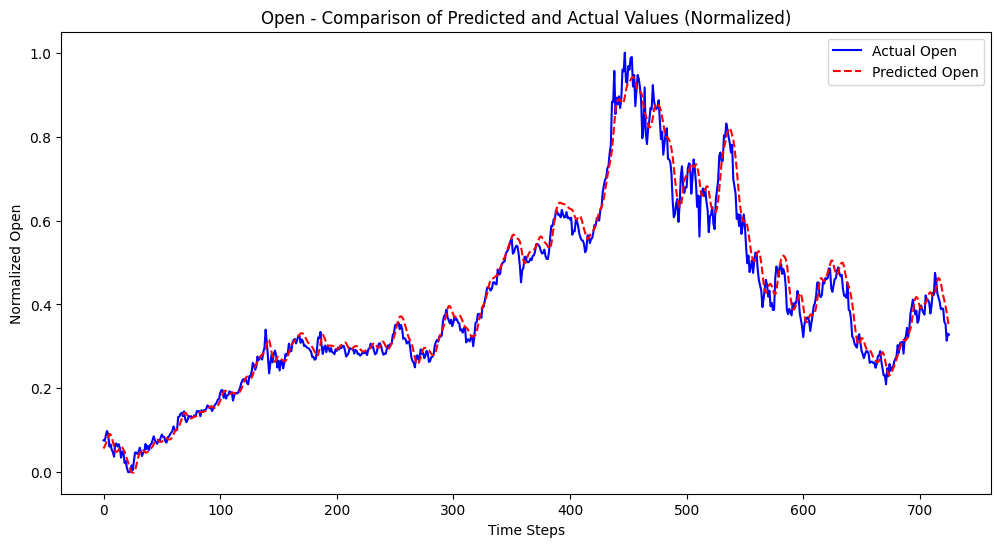

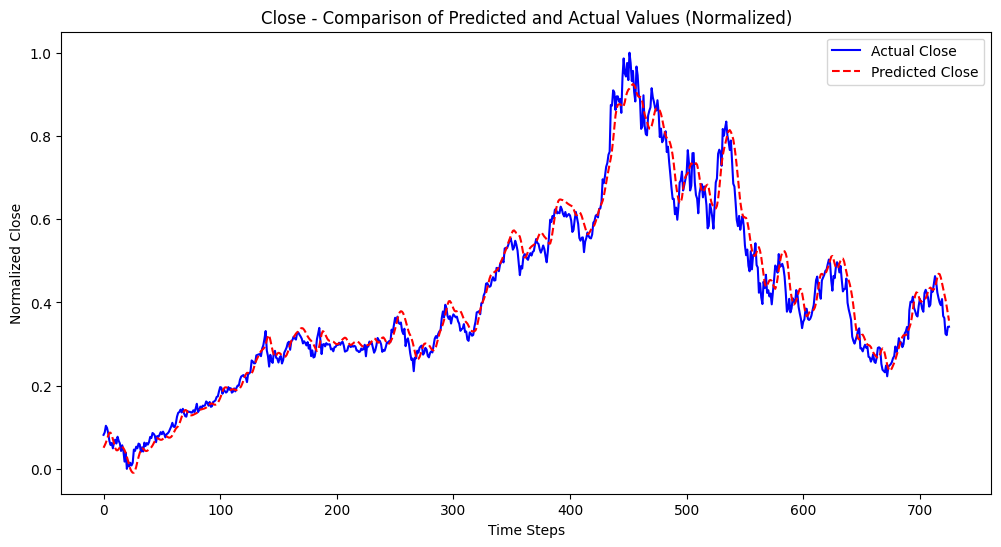

In [ ]:

RNNmodel = MultiFeatureRNN(input_size=2, hidden_size=50, output_size=2).to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(RNNmodel.parameters(), lr=0.0001)

RNNmodel,rnn_time = train_model(train_loader, val_loader, RNNmodel, criterion, optimizer)

predictions, actuals, mse_open, mse_close, mase_open, mase_close, allocated_memory, reserved_memory = evaluate_model(test_loader, RNNmodel)

results = {'train_time': rnn_time, 'allocated_memory': allocated_memory, 'reserved_memory': reserved_memory,
'mse_open':mse_open,'mse_close':mse_close, 'mase_open':mase_open, 'mase_close':mase_close}
results_dict[model_name[0]] = results

plot_results(predictions, actuals)

## torch.load (Loading weights)


In [ ]:
# Save the entire RNN model (weights and module class)
torch.save(RNNmodel, 'rnn2_model.pth')

# Load the entire RNN model (weights and module class)
model1 = torch.load('rnn2_model.pth')
model1.eval()




<ipython-input-10-faf4e1ec9889>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1 = torch.load('rnn2_model.pth')


MultiFeatureRNN(
  (rnn_layer1): RNN(2, 50, batch_first=True)
  (rnn_layer2): RNN(50, 50, batch_first=True)
  (rnn_layer3): RNN(50, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=2, bias=True)
)

### LTC

In [ ]:
class LTC(nn.Module):
    def __init__(self, input_size, hidden_size, tau=1.0):
        super(LTC, self).__init__()
        self.hidden_size = hidden_size
        self.input_weights = nn.Linear(input_size, hidden_size)
        self.hidden_weights = nn.Linear(hidden_size, hidden_size)
        self.tau = tau

    def forward(self, x, hidden_state):
        input_effect = self.input_weights(x) # x = I(t)
        hidden_effect = self.hidden_weights(hidden_state) # hidden state = X(t)
        combined = input_effect + hidden_effect # combined = A

        time_constant_effect = torch.sigmoid(combined) # time_constant_effect = f( x(t), I(t), t, theta )
        dynamic_time_constants = torch.clamp(self.tau / (1 + self.tau * time_constant_effect), min=0.1, max=1.0) # dynamic_time_constants = toll_sys

        # Calculate dx/dt
        dx_dt = time_constant_effect * combined - hidden_state / dynamic_time_constants # dx_dt = f( x(t), I(t), t, theta) * A - x(t) / toll_sys

        updated_hidden = hidden_state + dx_dt
        return updated_hidden, dx_dt

    def initialize_hidden_state(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size)

# Updated multi-layer LTC model, collecting dx/dt values
class MultiSequenceLTCModel(nn.Module):
    def __init__(self, input_size=2, hidden_size=30, output_size=2, tau1=1.0, tau2=1.0, tau3=1.0):
        super(MultiSequenceLTCModel, self).__init__()
        self.ltc_layer1 = LTC(input_size, hidden_size, tau=tau1)
        self.ltc_layer2 = LTC(hidden_size, hidden_size, tau=tau2)
        self.ltc_layer3 = LTC(hidden_size, hidden_size, tau=tau3)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size, seq_length, _ = x.size()
        hidden_state1 = self.ltc_layer1.initialize_hidden_state(batch_size).to(x.device)
        hidden_state2 = self.ltc_layer2.initialize_hidden_state(batch_size).to(x.device)
        hidden_state3 = self.ltc_layer3.initialize_hidden_state(batch_size).to(x.device)

        dx_dt_values = {'layer1': [], 'layer2': [], 'layer3': []}

        for t in range(seq_length):
            hidden_state1, dx_dt1 = self.ltc_layer1(x[:, t, :], hidden_state1)
            hidden_state2, dx_dt2 = self.ltc_layer2(hidden_state1, hidden_state2)
            hidden_state3, dx_dt3 = self.ltc_layer3(hidden_state2, hidden_state3)

            # Collect dx/dt values for each layer
            dx_dt_values['layer1'].append(dx_dt1)
            dx_dt_values['layer2'].append(dx_dt2)
            dx_dt_values['layer3'].append(dx_dt3)

        out = self.fc(hidden_state3)
        return out, dx_dt_values

In [ ]:
def train_LTC_model(train_loader, val_loader, model, criterion, optimizer, epochs=30):
    best_val_loss = float('inf')
    best_epoch = 0
    best_model_state = None
    epoch_dx_dt_history = []  # Records the average dx/dt values for each epoch

    start_time = time.time()
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        epoch_dx_dt_values = {'layer1': [], 'layer2': [], 'layer3': []}

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move data to GPU
            optimizer.zero_grad()
            output, dx_dt_values = model(X_batch)  # Assuming the model returns output and dx_dt_values
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # Collect the average dx/dt values for each batch
            for layer, values in dx_dt_values.items():
                epoch_dx_dt_values[layer].append(torch.stack(values).mean().item())

        # Calculate and record the average dx/dt values for each layer across the entire epoch
        avg_dx_dt = {layer: sum(values) / len(values) for layer, values in epoch_dx_dt_values.items()}

        # Calculate the average of the total dx/dt values across the three layers
        total_avg_dx_dt = sum(avg_dx_dt.values()) / len(avg_dx_dt)

        epoch_dx_dt_history.append({'total_avg_dx_dt': total_avg_dx_dt})

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                output, _ = model(X_batch)
                loss = criterion(output, y_batch)
                val_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_epoch = epoch + 1
            best_model_state = model.state_dict()

        print(f'Epoch {epoch+1}/{epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
        print(f'Average dx/dt values for each layer: {avg_dx_dt}, Average dx/dt value across three layers: {total_avg_dx_dt:.4f}')

    end_time = time.time()
    print(f"Total training time: {end_time - start_time:.2f} seconds")
    print(f"Best model at epoch {best_epoch}, Validation Loss: {best_val_loss:.4f}")
    model.load_state_dict(best_model_state)

    return model, end_time - start_time, epoch_dx_dt_history



In [ ]:
import plotly.graph_objs as go
def evaluate_LTC_model(test_loader, model):
    model.eval()
    with torch.no_grad():
        predictions, actuals = [], []
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output, _ = model(X_batch)
            predictions.extend(output.cpu().numpy())
            actuals.extend(y_batch.cpu().numpy())

    predictions = np.array(predictions)
    actuals = np.array(actuals)

    # Calculate MSE and MASE
    mse_open = mean_squared_error(actuals[:, 0], predictions[:, 0])
    mse_close = mean_squared_error(actuals[:, 1], predictions[:, 1])
    mase_open = calculate_mase(actuals[:, 0], predictions[:, 0])
    mase_close = calculate_mase(actuals[:, 1], predictions[:, 1])

    # Get the current GPU memory usage
    if torch.cuda.is_available():
        allocated_memory = torch.cuda.memory_allocated() / (1024 ** 2)
        reserved_memory = torch.cuda.memory_reserved() / (1024 ** 2)
    else:
        allocated_memory = reserved_memory = None

    print("Test set evaluation metrics (on normalized data):")
    print(f"Open - MSE: {mse_open:.4f}, MASE: {mase_open:.4f}")
    print(f"Close - MSE: {mse_close:.4f}, MASE: {mase_close:.4f}")

    if allocated_memory is not None and reserved_memory is not None:
        print(f"Memory allocated: {allocated_memory:.2f} MB")
        print(f"Memory reserved: {reserved_memory:.2f} MB")

    return predictions, actuals, mse_open, mse_close, mase_open, mase_close, allocated_memory, reserved_memory

# Visualization function to show the trend of dx/dt for each layer
def plot_dx_dt_history(epoch_dx_dt_history):

    epochs = list(range(1, len(epoch_dx_dt_history) + 1))

    # Get the names of the layers (e.g., 'layer1', 'layer2', 'layer3')
    layer_names = epoch_dx_dt_history[0].keys()

    fig = go.Figure()

    # Add a line for each layer to show the trend of dx/dt
    for layer in layer_names:
        # Collect the average dx/dt values for the current layer in each epoch
        layer_dx_dt_values = [epoch_data[layer] for epoch_data in epoch_dx_dt_history]

        fig.add_trace(go.Scatter(
            x=epochs,
            y=layer_dx_dt_values,
            mode='lines+markers',
            name=f'{layer} dx/dt',
            line=dict(width=2),
            marker=dict(size=6)
        ))

    fig.update_layout(
        title="Trend of dx/dt for Each Layer Across Epochs",
        xaxis_title="Epoch",
        yaxis_title="dx/dt Average Value",
        legend_title="Layer Name"
    )

    fig.show()

tau = 0.7

Epoch 1/30, Training Loss: 4874.3078, Validation Loss: 2349.9575
Average dx/dt values for each layer: {'layer1': 0.566274116168151, 'layer2': 0.6310384023833919, 'layer3': 1.0285050949534855}, Average dx/dt value across three layers: 0.7419
Epoch 2/30, Training Loss: 6421.6732, Validation Loss: 6048.6599
Average dx/dt values for each layer: {'layer1': 0.540215748387414, 'layer2': 0.6906691950720709, 'layer3': 1.2428542391673938}, Average dx/dt value across three layers: 0.8246
Epoch 3/30, Training Loss: 3786.5618, Validation Loss: 2619.2168
Average dx/dt values for each layer: {'layer1': 0.5588150725171372, 'layer2': 0.620474165355837, 'layer3': 0.9103705206432858}, Average dx/dt value across three layers: 0.6966
Epoch 4/30, Training Loss: 1960.9405, Validation Loss: 3427.1637
Average dx/dt values for each layer: {'layer1': 0.561938725613259, 'layer2': 0.5574819469774092, 'layer3': 0.8567670148772162}, Average dx/dt value across three layers: 0.6587
Epoch 5/30, Training Loss: 2215.1701

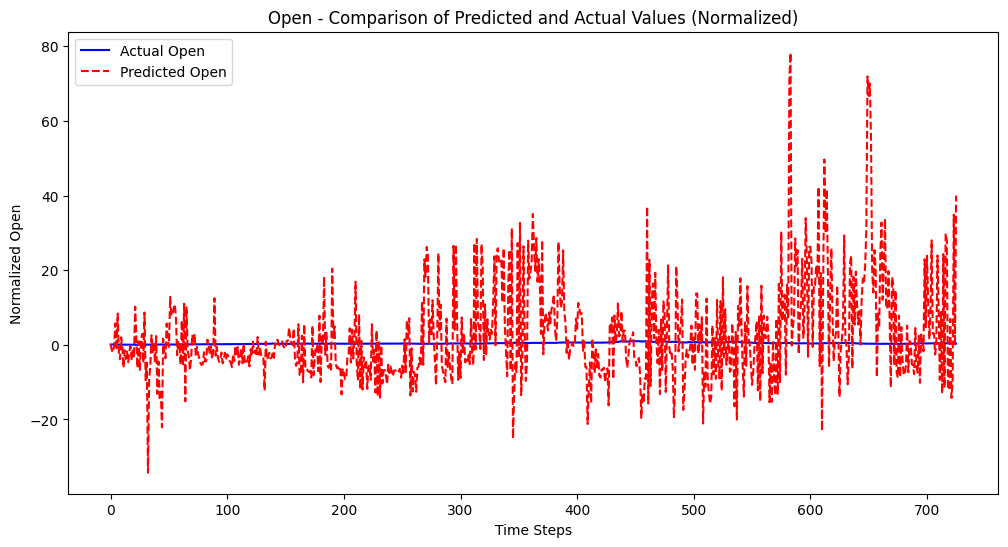

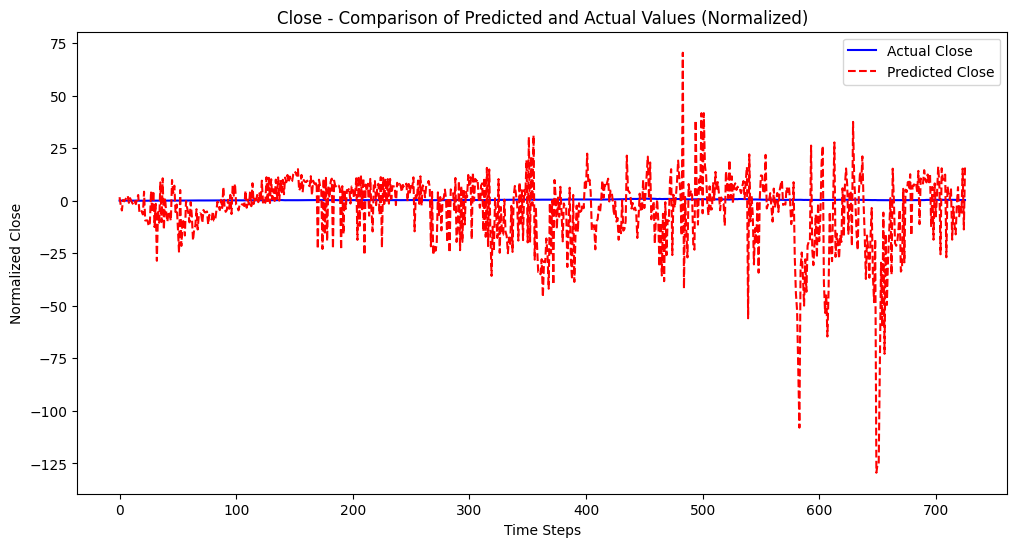

In [ ]:
ltc_1 = MultiSequenceLTCModel(input_size=2, hidden_size=50, output_size=2,tau1=0.7, tau2=0.7, tau3=0.7).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(ltc_1.parameters(), lr=0.0001)

ltc_1,ltc1_time,epoch_dx_dt_history = train_LTC_model(train_loader, val_loader, ltc_1, criterion, optimizer)


predictions, actuals, mse_open, mse_close, mase_open, mase_close, allocated_memory, reserved_memory = evaluate_LTC_model(test_loader, ltc_1)
results = {'train_time': ltc1_time, 'allocated_memory': allocated_memory, 'reserved_memory': reserved_memory, 'epoch_dx_dt_history':epoch_dx_dt_history,
 'mse_open':mse_open,'mse_close':mse_close, 'mase_open':mase_open, 'mase_close':mase_close}
results_dict[model_name[1]] = results

plot_results(predictions, actuals)

plot_dx_dt_history(epoch_dx_dt_history)

## This is the LTC model that generated results. The LTC models with tau>1 have generated the expected results.


tau = 1

Epoch 1/30, Training Loss: 0.2368, Validation Loss: 0.1394
Average dx/dt values for each layer: {'layer1': 0.0011980980351516926, 'layer2': 0.00034168339570405314, 'layer3': -0.00012819597385886654}, Average dx/dt value across three layers: 0.0005
Epoch 2/30, Training Loss: 0.1756, Validation Loss: 0.0766
Average dx/dt values for each layer: {'layer1': 0.0012544519393830687, 'layer2': 0.0006317391950712615, 'layer3': -0.0001859487165347673}, Average dx/dt value across three layers: 0.0006
Epoch 3/30, Training Loss: 0.0317, Validation Loss: 0.0098
Average dx/dt values for each layer: {'layer1': 0.001646198606043047, 'layer2': 0.002545639468243698, 'layer3': -0.00010352754459843807}, Average dx/dt value across three layers: 0.0014
Epoch 4/30, Training Loss: 0.0089, Validation Loss: 0.0068
Average dx/dt values for each layer: {'layer1': 0.0018183323806403456, 'layer2': 0.0034125061844148346, 'layer3': -0.0003836297701864906}, Average dx/dt value across three layers: 0.0016
Epoch 5/30, Tra

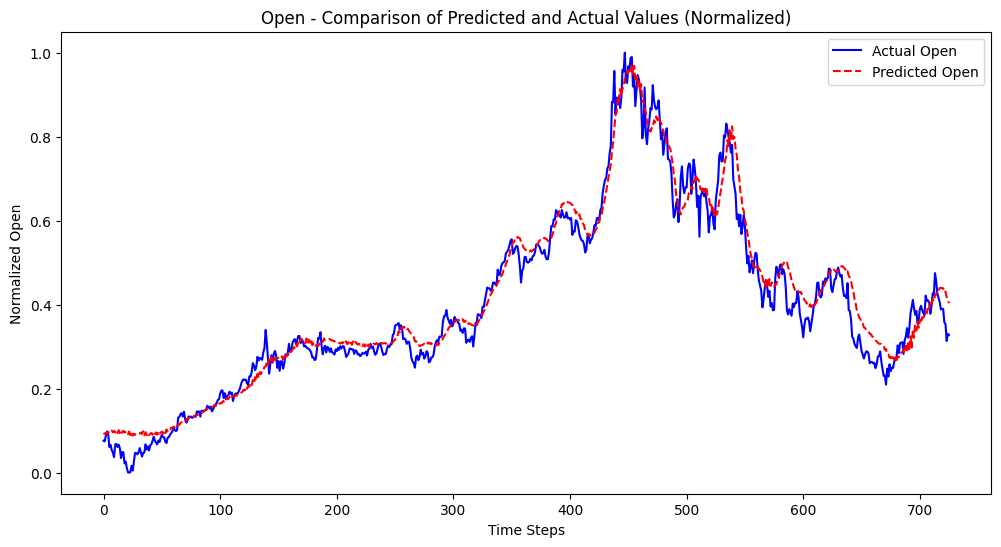

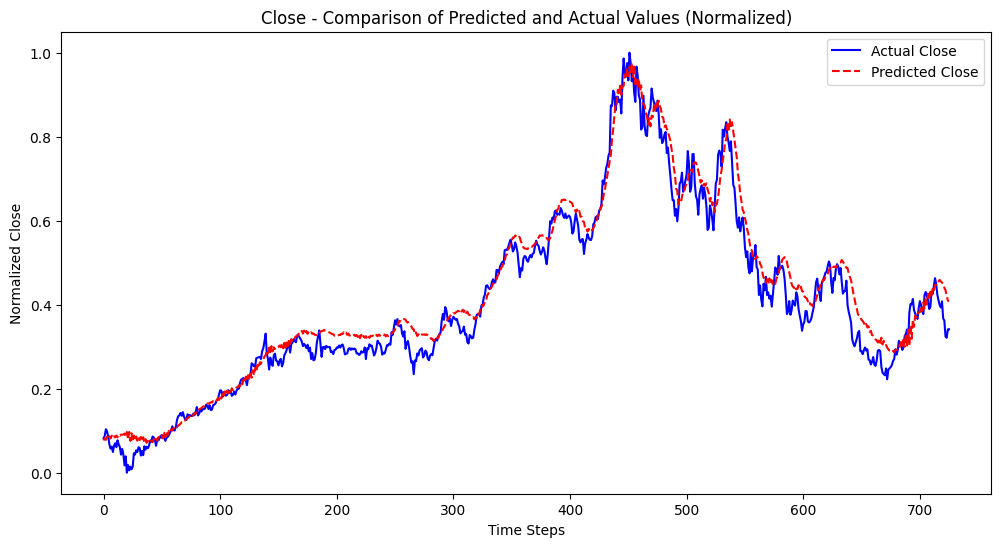

In [ ]:
ltc_2 = MultiSequenceLTCModel(input_size=2, hidden_size=50, output_size=2,tau1=1.0, tau2=1.0, tau3=1.0).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(ltc_2.parameters(), lr=0.0001)

ltc_2,ltc2_time,epoch_dx_dt_history = train_LTC_model(train_loader, val_loader, ltc_2, criterion, optimizer)


predictions, actuals, mse_open, mse_close, mase_open, mase_close, allocated_memory, reserved_memory = evaluate_LTC_model(test_loader, ltc_2)
results = {'train_time': ltc2_time, 'allocated_memory': allocated_memory, 'reserved_memory': reserved_memory, 'epoch_dx_dt_history':epoch_dx_dt_history,
 'mse_open':mse_open,'mse_close':mse_close, 'mase_open':mase_open, 'mase_close':mase_close}
results_dict[model_name[2]] = results

plot_results(predictions, actuals)

plot_dx_dt_history(epoch_dx_dt_history)

##torch.load (Loading weights)


In [ ]:
torch.save(ltc_2, 'ltc2_model.pth')


model2 = torch.load('ltc2_model.pth')
model2.eval()

<ipython-input-16-73696dab2e37>:4: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



MultiSequenceLTCModel(
  (ltc_layer1): LTC(
    (input_weights): Linear(in_features=2, out_features=50, bias=True)
    (hidden_weights): Linear(in_features=50, out_features=50, bias=True)
  )
  (ltc_layer2): LTC(
    (input_weights): Linear(in_features=50, out_features=50, bias=True)
    (hidden_weights): Linear(in_features=50, out_features=50, bias=True)
  )
  (ltc_layer3): LTC(
    (input_weights): Linear(in_features=50, out_features=50, bias=True)
    (hidden_weights): Linear(in_features=50, out_features=50, bias=True)
  )
  (fc): Linear(in_features=50, out_features=2, bias=True)
)

tau=10.0

Epoch 1/30, Training Loss: 0.1391, Validation Loss: 0.0476
Average dx/dt values for each layer: {'layer1': 0.0015083115321357509, 'layer2': 0.000801286191327145, 'layer3': -0.0003141880238340614}, Average dx/dt value across three layers: 0.0007
Epoch 2/30, Training Loss: 0.0895, Validation Loss: 0.0130
Average dx/dt values for each layer: {'layer1': 0.0018067130240032802, 'layer2': 0.0011423713420643598, 'layer3': -0.0001952607012385301}, Average dx/dt value across three layers: 0.0009
Epoch 3/30, Training Loss: 0.0416, Validation Loss: 0.0060
Average dx/dt values for each layer: {'layer1': 0.002278385520283435, 'layer2': 0.002012566719959314, 'layer3': 0.00021221869863782903}, Average dx/dt value across three layers: 0.0015
Epoch 4/30, Training Loss: 0.0225, Validation Loss: 0.0038
Average dx/dt values for each layer: {'layer1': 0.0025027681116920873, 'layer2': 0.0027142462408723863, 'layer3': 0.0006974898797862634}, Average dx/dt value across three layers: 0.0020
Epoch 5/30, Training

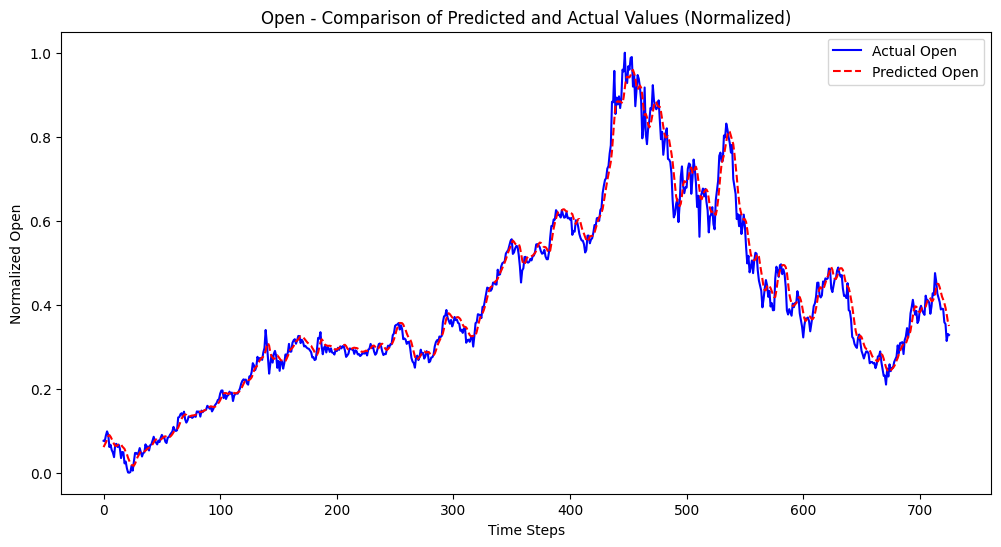

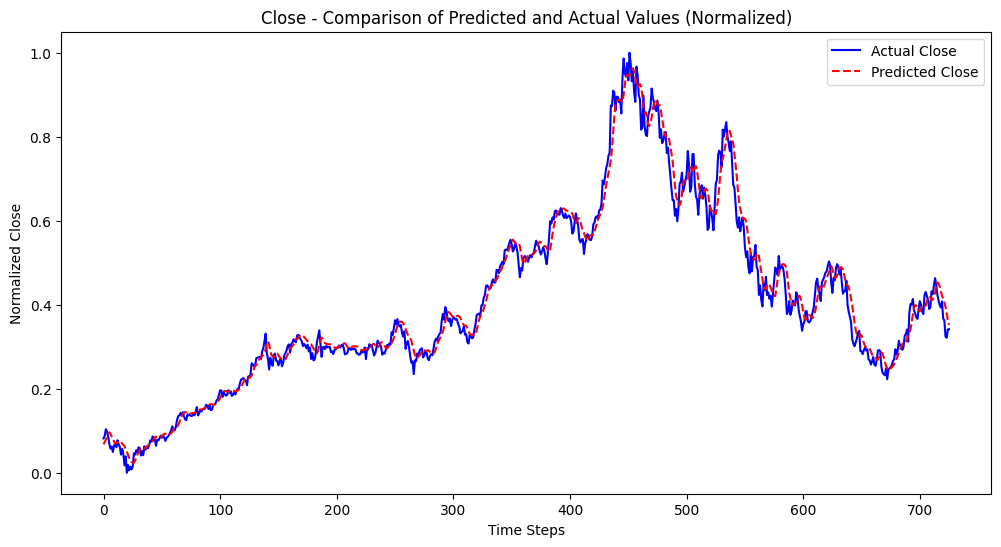

In [ ]:
ltc_3 = MultiSequenceLTCModel(input_size=2, hidden_size=50, output_size=2,tau1=10.0, tau2=10.0, tau3=10.0).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(ltc_3.parameters(), lr=0.0001)

ltc_3,ltc3_time,epoch_dx_dt_history = train_LTC_model(train_loader, val_loader, ltc_3, criterion, optimizer)


predictions, actuals, mse_temp, mse_humidity, mase_temp, mase_humidity, allocated_memory, reserved_memory = evaluate_LTC_model(test_loader, ltc_3)
results = {'train_time': ltc3_time, 'allocated_memory': allocated_memory, 'reserved_memory': reserved_memory, 'epoch_dx_dt_history':epoch_dx_dt_history,
 'mse_open':mse_open,'mse_close':mse_close, 'mase_open':mase_open, 'mase_close':mase_close}
results_dict[model_name[3]] = results

plot_results(predictions, actuals)

plot_dx_dt_history(epoch_dx_dt_history)

In [ ]:
torch.save(ltc_3, 'ltc3_model.pth')


model2 = torch.load('ltc3_model.pth')
model2.eval()

<ipython-input-21-9886515d796b>:4: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



MultiSequenceLTCModel(
  (ltc_layer1): LTC(
    (input_weights): Linear(in_features=2, out_features=50, bias=True)
    (hidden_weights): Linear(in_features=50, out_features=50, bias=True)
  )
  (ltc_layer2): LTC(
    (input_weights): Linear(in_features=50, out_features=50, bias=True)
    (hidden_weights): Linear(in_features=50, out_features=50, bias=True)
  )
  (ltc_layer3): LTC(
    (input_weights): Linear(in_features=50, out_features=50, bias=True)
    (hidden_weights): Linear(in_features=50, out_features=50, bias=True)
  )
  (fc): Linear(in_features=50, out_features=2, bias=True)
)

tau=100.0

Epoch 1/30, Training Loss: 0.2215, Validation Loss: 0.1093
Average dx/dt values for each layer: {'layer1': 0.0024112992152269625, 'layer2': -0.00022368259394440698, 'layer3': 0.0006918101209668896}, Average dx/dt value across three layers: 0.0010
Epoch 2/30, Training Loss: 0.1485, Validation Loss: 0.0418
Average dx/dt values for each layer: {'layer1': 0.002653283010413115, 'layer2': -0.00017368736297538744, 'layer3': 0.0013197739702976636}, Average dx/dt value across three layers: 0.0013
Epoch 3/30, Training Loss: 0.0539, Validation Loss: 0.0106
Average dx/dt values for each layer: {'layer1': 0.0033593579270952455, 'layer2': 0.0003606487004396292, 'layer3': 0.0031476484429141557}, Average dx/dt value across three layers: 0.0023
Epoch 4/30, Training Loss: 0.0234, Validation Loss: 0.0044
Average dx/dt values for each layer: {'layer1': 0.0038511635030846337, 'layer2': 0.0009008403993337541, 'layer3': 0.004692871702482572}, Average dx/dt value across three layers: 0.0031
Epoch 5/30, Traini

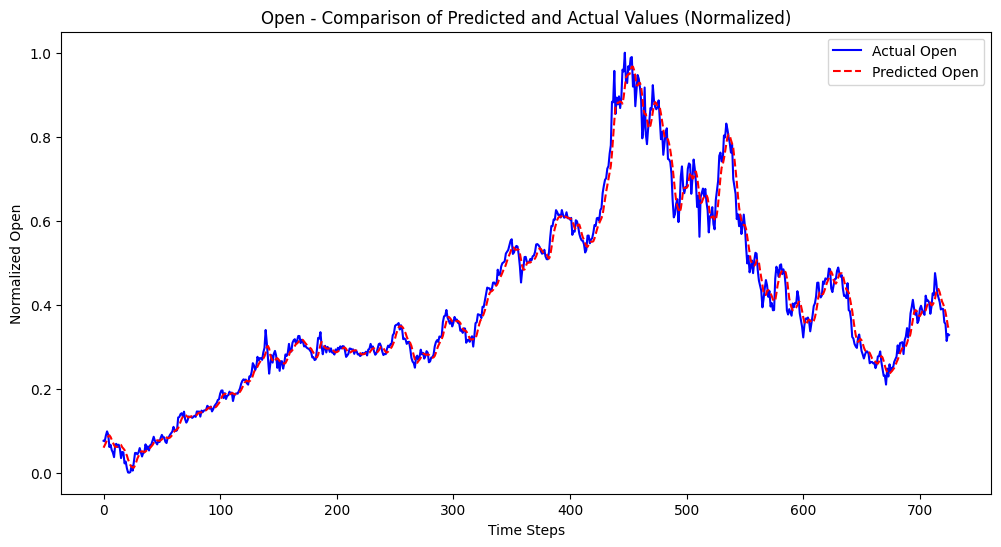

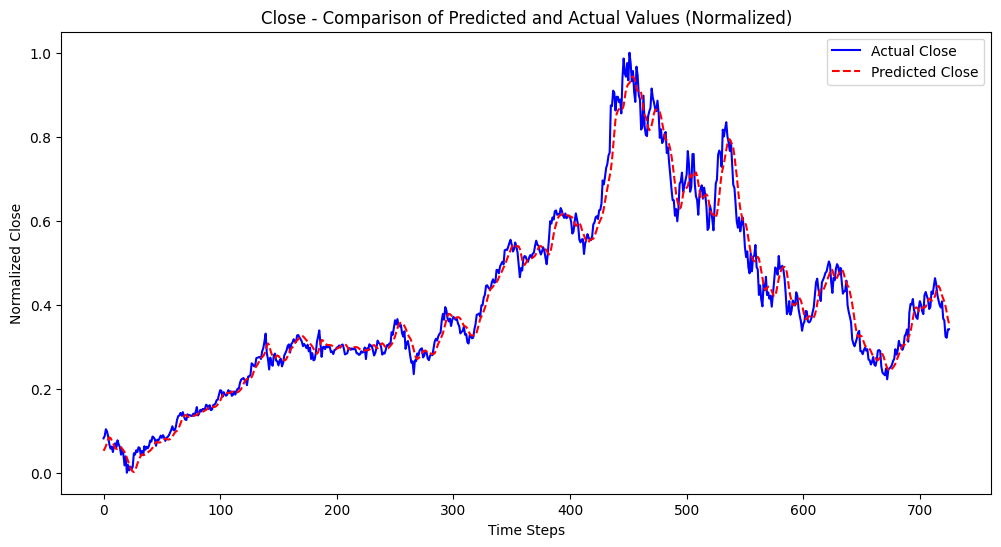

In [ ]:

ltc_4 = MultiSequenceLTCModel(input_size=2, hidden_size=50, output_size=2,tau1=100.0, tau2=100.0, tau3=100.0).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(ltc_4.parameters(), lr=0.0001)

ltc_4,ltc4_time,epoch_dx_dt_history = train_LTC_model(train_loader, val_loader, ltc_4, criterion, optimizer)


predictions, actuals, mse_open, mse_close, mase_open, mase_close, allocated_memory, reserved_memory = evaluate_LTC_model(test_loader, ltc_4)
results = {'train_time': ltc4_time, 'allocated_memory': allocated_memory, 'reserved_memory': reserved_memory, 'epoch_dx_dt_history':epoch_dx_dt_history,
 'mse_open':mse_open,'mse_close':mse_close, 'mase_open':mase_open, 'mase_close':mase_close}
results_dict[model_name[4]] = results

plot_results(predictions, actuals)

plot_dx_dt_history(epoch_dx_dt_history)

In [ ]:
torch.save(ltc_4, 'ltc4_model.pth')


model2 = torch.load('ltc4_model.pth')
model2.eval()

<ipython-input-22-129d1fa4df80>:4: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



MultiSequenceLTCModel(
  (ltc_layer1): LTC(
    (input_weights): Linear(in_features=2, out_features=50, bias=True)
    (hidden_weights): Linear(in_features=50, out_features=50, bias=True)
  )
  (ltc_layer2): LTC(
    (input_weights): Linear(in_features=50, out_features=50, bias=True)
    (hidden_weights): Linear(in_features=50, out_features=50, bias=True)
  )
  (ltc_layer3): LTC(
    (input_weights): Linear(in_features=50, out_features=50, bias=True)
    (hidden_weights): Linear(in_features=50, out_features=50, bias=True)
  )
  (fc): Linear(in_features=50, out_features=2, bias=True)
)

multi_tau:tau1=1.0, tau2=10.0, tau3=100.0

Epoch 1/30, Training Loss: 0.1796, Validation Loss: 0.0838
Average dx/dt values for each layer: {'layer1': 0.0014108558330131141, 'layer2': 0.0007662951562402619, 'layer3': -4.211104321773353e-05}, Average dx/dt value across three layers: 0.0007
Epoch 2/30, Training Loss: 0.1368, Validation Loss: 0.0473
Average dx/dt values for each layer: {'layer1': 0.0015303453405362529, 'layer2': 0.0008574451848461822, 'layer3': -6.586922323991973e-05}, Average dx/dt value across three layers: 0.0008
Epoch 3/30, Training Loss: 0.0797, Validation Loss: 0.0089
Average dx/dt values for each layer: {'layer1': 0.0017977589835740022, 'layer2': 0.0011056511524460606, 'layer3': 5.469425793086663e-05}, Average dx/dt value across three layers: 0.0010
Epoch 4/30, Training Loss: 0.0256, Validation Loss: 0.0063
Average dx/dt values for each layer: {'layer1': 0.0028390965606966937, 'layer2': 0.0021405471520297027, 'layer3': 0.0007884768144592542}, Average dx/dt value across three layers: 0.0019
Epoch 5/30, Traini

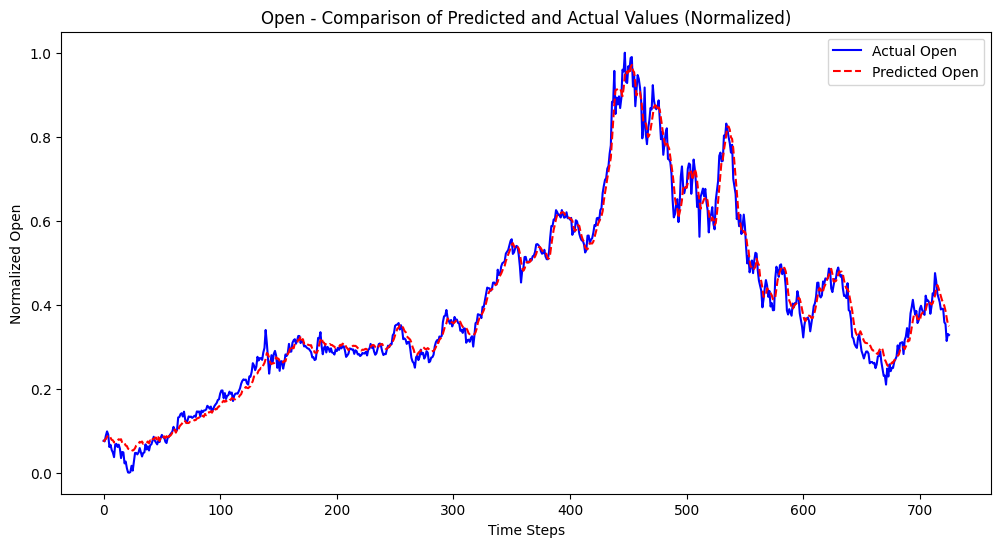

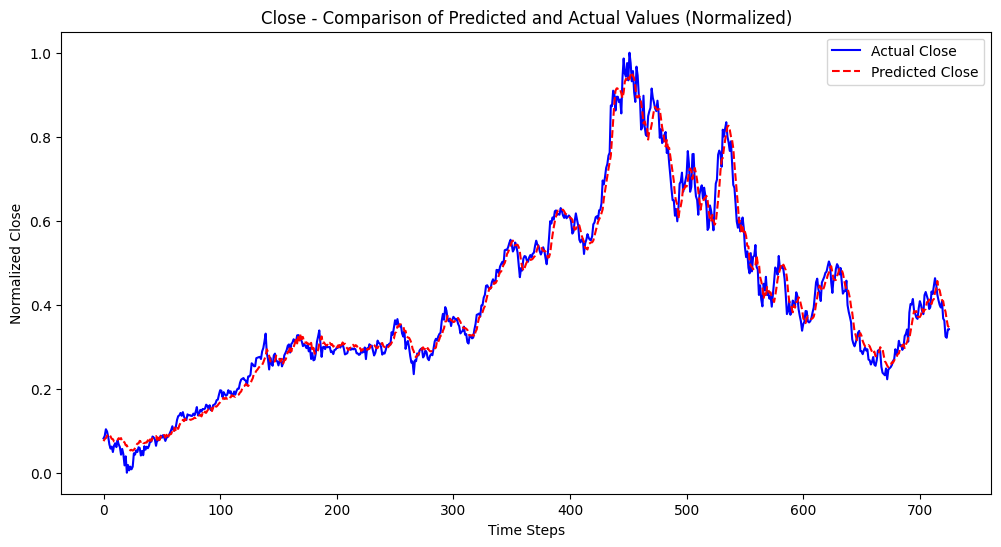

In [ ]:

ltc_5 = MultiSequenceLTCModel(input_size=2, hidden_size=50, output_size=2,tau1=1.0, tau2=10.0, tau3=100.0).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(ltc_5.parameters(), lr=0.0001)

ltc_5,ltc5_time,epoch_dx_dt_history = train_LTC_model(train_loader, val_loader, ltc_5, criterion, optimizer)

predictions, actuals, mse_open, mse_close, mase_open, mase_close, allocated_memory, reserved_memory = evaluate_LTC_model(test_loader, ltc_5)
results = {'train_time': ltc5_time, 'allocated_memory': allocated_memory, 'reserved_memory': reserved_memory, 'epoch_dx_dt_history':epoch_dx_dt_history,
 'mse_open':mse_open,'mse_close':mse_close, 'mase_open':mase_open, 'mase_close':mase_close}
results_dict[model_name[5]] = results

plot_results(predictions, actuals)

plot_dx_dt_history(epoch_dx_dt_history)

In [ ]:
torch.save(ltc_5, 'ltc5_model.pth')


model2 = torch.load('ltc5_model.pth')
model2.eval()

<ipython-input-24-6ff7b61a5cac>:4: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



MultiSequenceLTCModel(
  (ltc_layer1): LTC(
    (input_weights): Linear(in_features=2, out_features=50, bias=True)
    (hidden_weights): Linear(in_features=50, out_features=50, bias=True)
  )
  (ltc_layer2): LTC(
    (input_weights): Linear(in_features=50, out_features=50, bias=True)
    (hidden_weights): Linear(in_features=50, out_features=50, bias=True)
  )
  (ltc_layer3): LTC(
    (input_weights): Linear(in_features=50, out_features=50, bias=True)
    (hidden_weights): Linear(in_features=50, out_features=50, bias=True)
  )
  (fc): Linear(in_features=50, out_features=2, bias=True)
)

In [ ]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

def visualize_model_results(results_dict):

    model_names = list(results_dict.keys())

    metrics_to_visualize = ['train_time', 'allocated_memory', 'reserved_memory', 'epoch_dx_dt_history',
                            'mse_open', 'mse_close', 'mase_open', 'mase_close']

    # Create subplots with 2 columns and one metric per subplot
    num_metrics = len(metrics_to_visualize)
    fig = make_subplots(rows=(num_metrics + 1) // 2, cols=2,
                        subplot_titles=[metric.replace('_', ' ').title() for metric in metrics_to_visualize])

    for i, metric in enumerate(metrics_to_visualize):
        # Determine the current subplot position
        row = i // 2 + 1
        col = i % 2 + 1

        for model in model_names:
            metrics = results_dict[model]

            if metric in ['train_time', 'allocated_memory', 'reserved_memory', 'mse_open', 'mse_close', 'mase_open', 'mase_close']:
                value = metrics.get(metric)
                if value is not None:

                    fig.add_trace(go.Bar(
                        x=[model],
                        y=[value],
                        name=metric.replace('_', ' ').title(),
                        text=[f"{value:.4f}" if metric != 'epoch_dx_dt_history' else ""],
                        texttemplate='%{text}',
                        textposition='outside'
                    ), row=row, col=col)

            elif metric == 'epoch_dx_dt_history' and model != 'rnn':
                dx_dt_values = [entry['total_avg_dx_dt'] for entry in metrics['epoch_dx_dt_history']]
                epochs = list(range(1, len(dx_dt_values) + 1))

                fig.add_trace(go.Scatter(
                    x=epochs,
                    y=dx_dt_values,
                    mode='lines+markers',
                    name=model,
                    text=[f"{val:.6f}" for val in dx_dt_values],
                    textposition='top center'
                ), row=row, col=col)

        fig.update_xaxes(title_text="Models" if metric != 'epoch_dx_dt_history' else "Epochs", row=row, col=col)
        fig.update_yaxes(title_text=metric.replace('_', ' ').title(), row=row, col=col)

    fig.update_layout(
        title="Model Performance Metrics",
        legend_title="Metrics",
        height=1600,
        showlegend=True
    )

    fig.show()

# Usage example
# visualize_model_results(results_dict)


In [ ]:

visualize_model_results(results_dict)


##CNN-LSTM

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import yfinance as yf

# Define the CNN-LSTM model class
class CNNLSTMModel(nn.Module):
    def __init__(self):
        super(CNNLSTMModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=16, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.lstm = nn.LSTM(input_size=16, hidden_size=64, batch_first=True)
        self.fc = nn.Linear(64, 2)

    def forward(self, x):
        x = x.transpose(1, 2)  # [batch, features, sequence]
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.transpose(1, 2)  # [batch, sequence, features]
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :])
        return x

# Function to create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        seq = data[i:(i + seq_length)]
        X.append(seq)
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Load data
def load_data():
    stock_data = yf.download('NVDA', start='2020-01-01', end='2023-01-01')
    features = stock_data[['Open', 'Close']].values
    scaler = MinMaxScaler(feature_range=(0, 1))
    features_scaled = scaler.fit_transform(features)
    seq_length = 30
    X, y = create_sequences(features_scaled, seq_length)
    split_ratio = 0.8
    split = int(len(X) * split_ratio)
    X_train, X_val = X[:split], X[split:]
    y_train, y_val = y[:split], y[split:]
    return torch.Tensor(X_train).to(device), torch.Tensor(y_train).to(device), torch.Tensor(X_val).to(device), torch.Tensor(y_val).to(device)

# Training function
def train_model(train_loader, val_loader, model, criterion, optimizer, epochs=30):
    model.train()
    start_time = time.time()
    for epoch in range(epochs):
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        print(f'Epoch {epoch+1}/{epochs}, Training Loss: {train_loss / len(train_loader):.4f}')
    end_time = time.time()
    print(f"Total training time: {end_time - start_time:.2f} seconds")
    return model

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNNLSTMModel().to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Load and prepare data
X_train, y_train, X_val, y_val = load_data()
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=16, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=16)

# Train the model
model = train_model(train_loader, val_loader, model, criterion, optimizer, epochs=30)


[*********************100%***********************]  1 of 1 completed


Epoch 1/30, Training Loss: 0.0591
Epoch 2/30, Training Loss: 0.0034
Epoch 3/30, Training Loss: 0.0023
Epoch 4/30, Training Loss: 0.0020
Epoch 5/30, Training Loss: 0.0018
Epoch 6/30, Training Loss: 0.0019
Epoch 7/30, Training Loss: 0.0015
Epoch 8/30, Training Loss: 0.0013
Epoch 9/30, Training Loss: 0.0014
Epoch 10/30, Training Loss: 0.0012
Epoch 11/30, Training Loss: 0.0011
Epoch 12/30, Training Loss: 0.0010
Epoch 13/30, Training Loss: 0.0011
Epoch 14/30, Training Loss: 0.0010
Epoch 15/30, Training Loss: 0.0009
Epoch 16/30, Training Loss: 0.0009
Epoch 17/30, Training Loss: 0.0009
Epoch 18/30, Training Loss: 0.0008
Epoch 19/30, Training Loss: 0.0008
Epoch 20/30, Training Loss: 0.0008
Epoch 21/30, Training Loss: 0.0008
Epoch 22/30, Training Loss: 0.0007
Epoch 23/30, Training Loss: 0.0009
Epoch 24/30, Training Loss: 0.0008
Epoch 25/30, Training Loss: 0.0007
Epoch 26/30, Training Loss: 0.0007
Epoch 27/30, Training Loss: 0.0009
Epoch 28/30, Training Loss: 0.0007
Epoch 29/30, Training Loss: 0